# Setup

Loading obs data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.33it/s]


Loading model data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Calculating absolute error and field mean of abs error


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.52s/it]


Writing field mean of errors into csv files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


Reading precalculated cmip6 field mean of errors from csv files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.09it/s]


Placing sums of error into easier to inspect dictionary
Calculating ratio of current model error to evaluation model error


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 43.97it/s]


Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


Plotting heatmap(s)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


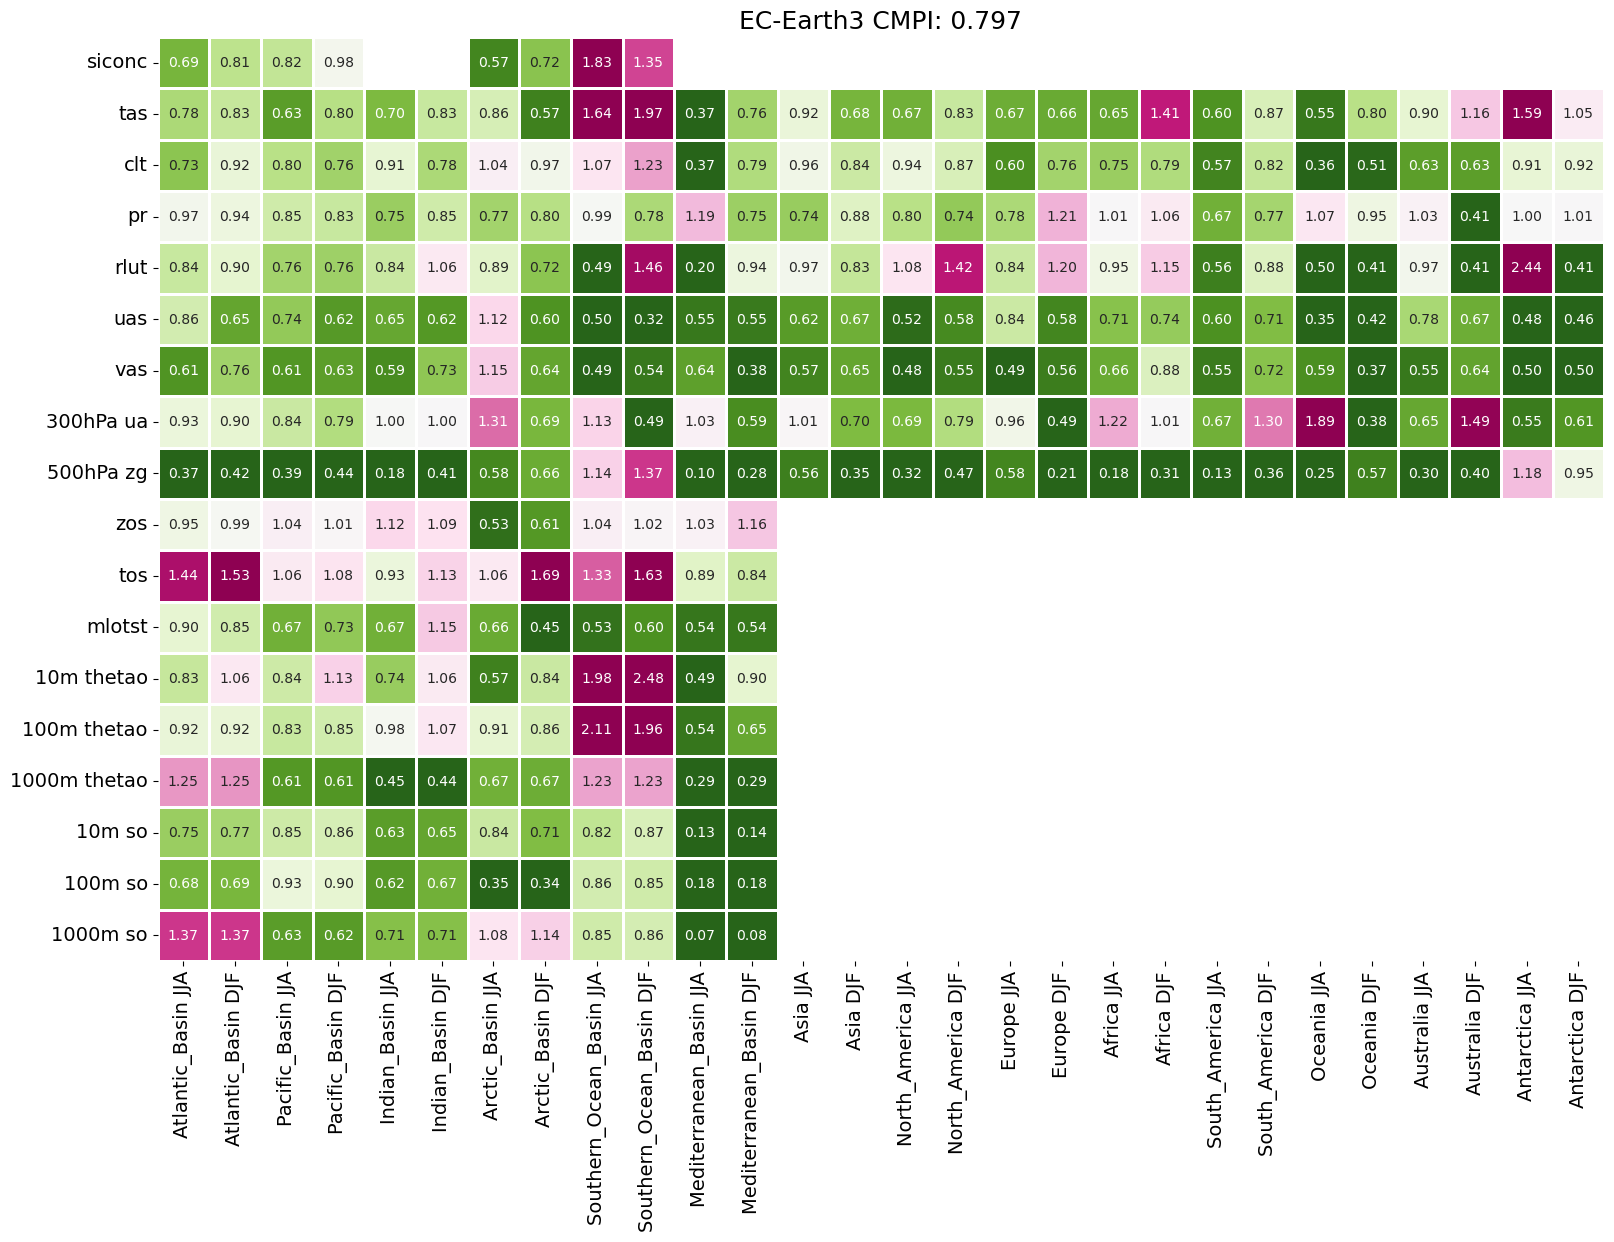

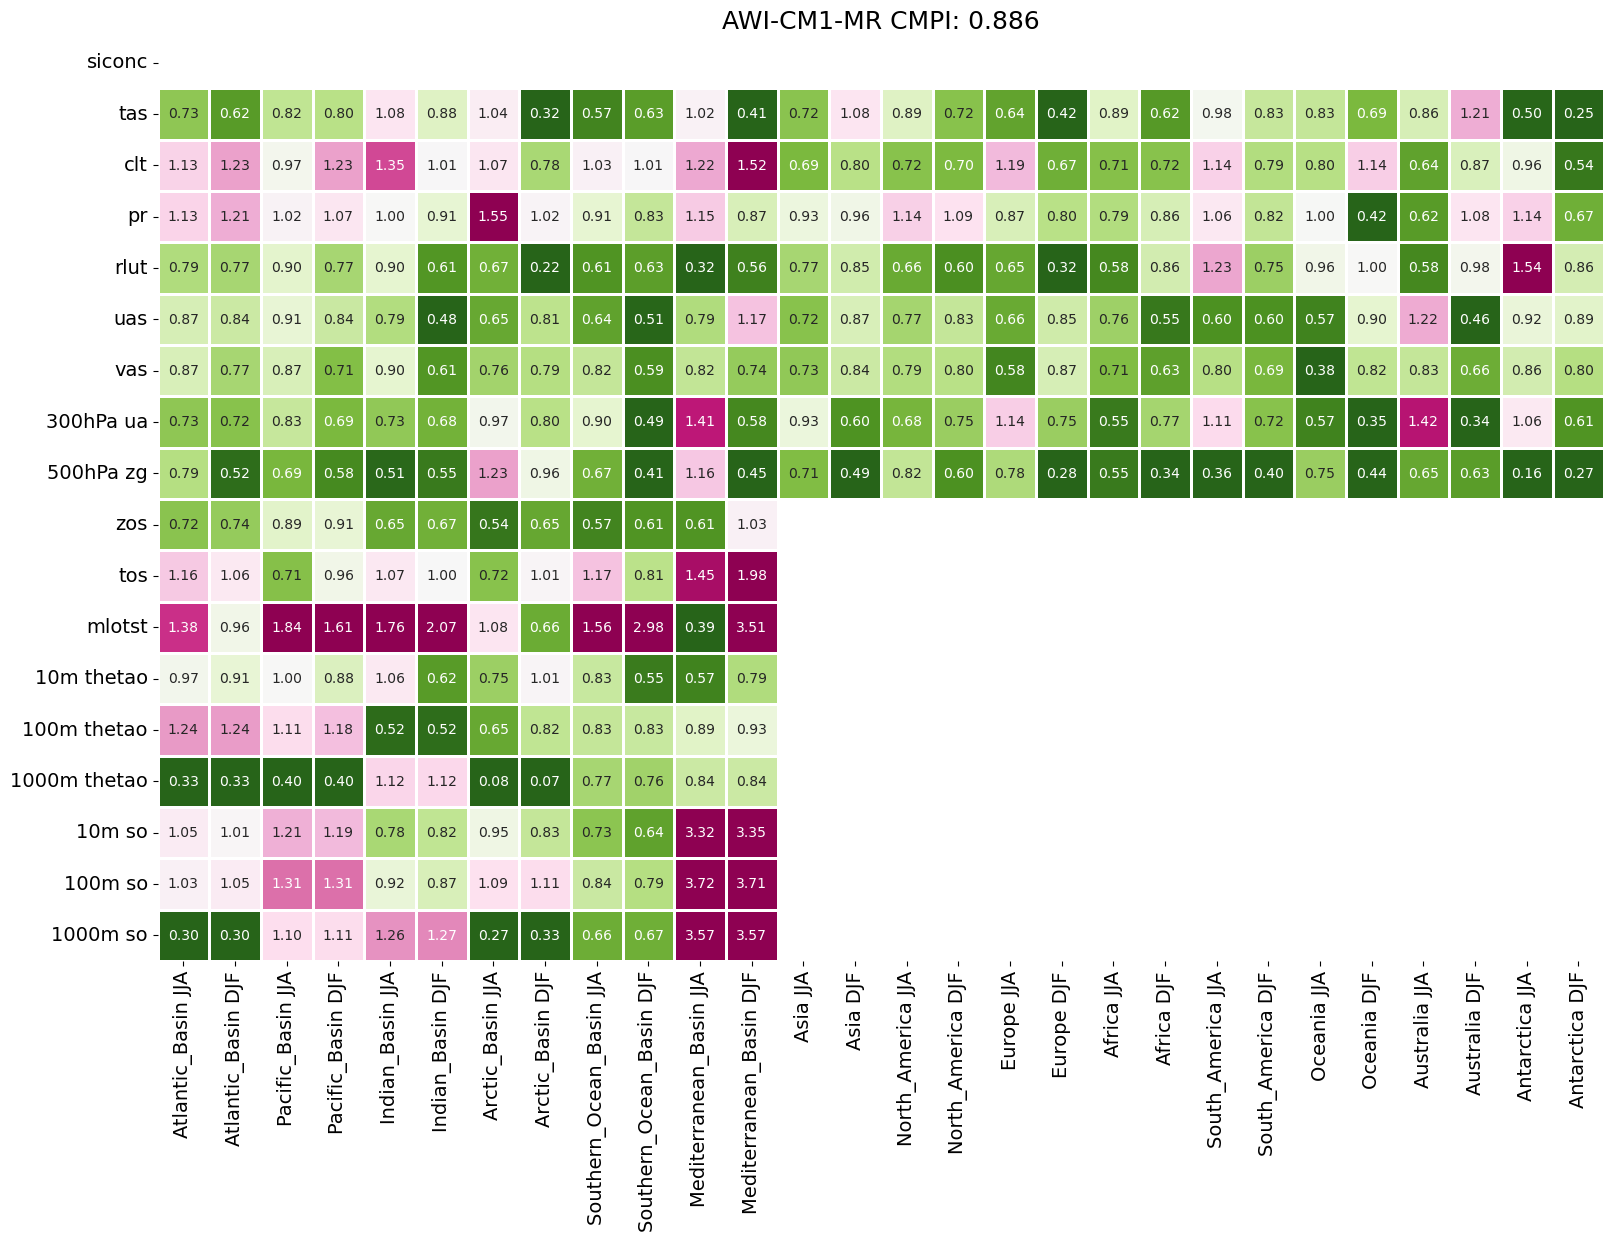

In [2]:
from cmpitool import (cmpitool ,cmpisetup)

variable, region, climate_model, siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so = cmpisetup()
model_path='/p/project/chhb19/streffing1/software/cmpi-tool/input/'
models=[    
        climate_model(name='EC-Earth3',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
        climate_model(name='AWI-CM1-MR',   variables=[        tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    ]

cmpitool(model_path, models, seasons=['JJA', 'DJF'], complexity='regions')